In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb early
!pip install evaluate

import torch
print("CUDA available:", torch.cuda.is_available())

from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# Load dataset
df = pd.read_csv("/kaggle/input/text-document-classification-dataset/df_file.csv")

# Rename label column to 'labels' for Trainer compatibility
df = df.rename(columns={"Label": "labels", "Text": "text"})

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split dataset
total = len(df)
train_size = int(0.8 * total)
val_size = int(0.1 * total)

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Convert to HF Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function (make sure to keep labels)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Important: set format for PyTorch tensors and keep labels
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model for 5-class classification (num_labels=5)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Load evaluation metrics once
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="finetuned-text-classify",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=False,
    run_name="my_unique_run_name"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,  # Use validation dataset here
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
trainer.evaluate()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 627.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvi

2025-08-11 09:13:09.287813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754903589.473359      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754903589.527311      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train: 1780, Validation: 222, Test: 223


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/3339566117.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'eval_loss': 0.05246339365839958,
 'eval_accuracy': 0.9954954954954955,
 'eval_precision': 0.9955745218903114,
 'eval_recall': 0.9954954954954955,
 'eval_f1': 0.9954772531643687,
 'eval_runtime': 1.8069,
 'eval_samples_per_second': 122.859,
 'eval_steps_per_second': 7.748,
 'epoch': 2.0}

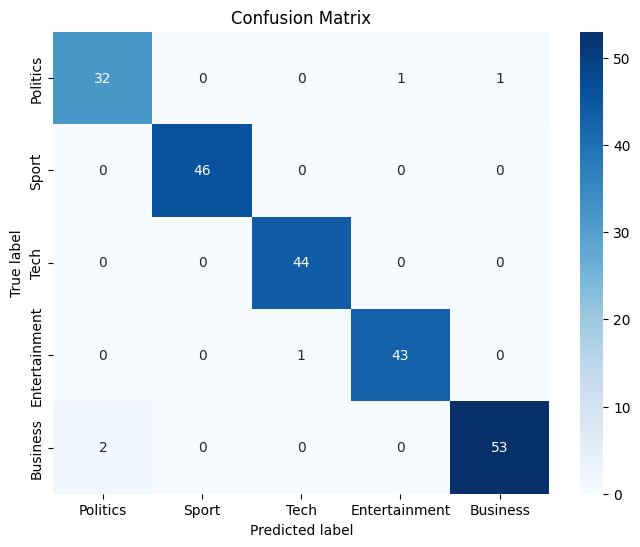

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppose you have predictions and true labels after evaluation or prediction:
# Example: after trainer.predict(test_dataset)

predictions_output = trainer.predict(tokenized_test)
logits = predictions_output.predictions
labels = predictions_output.label_ids

import numpy as np
preds = np.argmax(logits, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'],
            yticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [3]:
from sklearn.metrics import classification_report, accuracy_score

# Run predictions on the test dataset
predictions_output = trainer.predict(tokenized_test)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted class indices
preds = np.argmax(logits, axis=-1)

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
target_names = ['Politics', 'Sport', 'Tech', 'Entertainment', 'Business']
report = classification_report(true_labels, preds, target_names=target_names)
print("Classification Report:\n", report)


Test Accuracy: 0.9776
Classification Report:
                precision    recall  f1-score   support

     Politics       0.94      0.94      0.94        34
        Sport       1.00      1.00      1.00        46
         Tech       0.98      1.00      0.99        44
Entertainment       0.98      0.98      0.98        44
     Business       0.98      0.96      0.97        55

     accuracy                           0.98       223
    macro avg       0.98      0.98      0.98       223
 weighted avg       0.98      0.98      0.98       223



In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb early

import torch
print("CUDA available:", torch.cuda.is_available())

from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# Load dataset
df = pd.read_csv("/kaggle/input/text-document-classification-dataset/df_file.csv")

# Rename columns for HF Trainer
df = df.rename(columns={"Label": "labels", "Text": "text"})

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split dataset
total = len(df)
train_size = int(0.8 * total)
val_size = int(0.1 * total)

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch and keep labels
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load RoBERTa model for sequence classification with 5 classes
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=5)

# Load metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="finetuned-roberta-text-classify",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=False,
    run_name="roberta_text_classify_run"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
trainer.evaluate()


CUDA available: True
Train: 1780, Validation: 222, Test: 223


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/244136613.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'eval_loss': 0.004537810105830431,
 'eval_accuracy': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 3.4987,
 'eval_samples_per_second': 63.453,
 'eval_steps_per_second': 4.002,
 'epoch': 2.0}

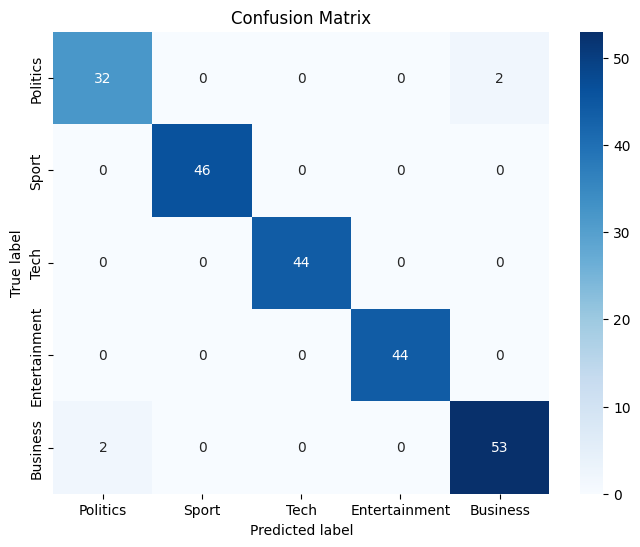

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppose you have predictions and true labels after evaluation or prediction:
# Example: after trainer.predict(test_dataset)

predictions_output = trainer.predict(tokenized_test)
logits = predictions_output.predictions
labels = predictions_output.label_ids

import numpy as np
preds = np.argmax(logits, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'],
            yticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [6]:
from sklearn.metrics import classification_report, accuracy_score

# Run predictions on the test dataset
predictions_output = trainer.predict(tokenized_test)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted class indices
preds = np.argmax(logits, axis=-1)

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
target_names = ['Politics', 'Sport', 'Tech', 'Entertainment', 'Business']
report = classification_report(true_labels, preds, target_names=target_names)
print("Classification Report:\n", report)


Test Accuracy: 0.9821
Classification Report:
                precision    recall  f1-score   support

     Politics       0.94      0.94      0.94        34
        Sport       1.00      1.00      1.00        46
         Tech       1.00      1.00      1.00        44
Entertainment       1.00      1.00      1.00        44
     Business       0.96      0.96      0.96        55

     accuracy                           0.98       223
    macro avg       0.98      0.98      0.98       223
 weighted avg       0.98      0.98      0.98       223



In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb early

import torch
print("CUDA available:", torch.cuda.is_available())

from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# Load dataset
df = pd.read_csv("/kaggle/input/text-document-classification-dataset/df_file.csv")

# Rename label column to 'labels' for Trainer compatibility
df = df.rename(columns={"Label": "labels", "Text": "text"})

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split dataset
total = len(df)
train_size = int(0.8 * total)
val_size = int(0.1 * total)

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Load ALBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function (keep labels)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors and keep labels
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load ALBERT model for sequence classification with 5 classes
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=5)

# Load metrics once
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="finetuned-albert-text-classify",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=False,
    run_name="albert_text_classify_run"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
trainer.evaluate()


CUDA available: True
Train: 1780, Validation: 222, Test: 223


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/1317116513.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'eval_loss': 0.048338234424591064,
 'eval_accuracy': 0.990990990990991,
 'eval_precision': 0.9913016464740604,
 'eval_recall': 0.990990990990991,
 'eval_f1': 0.9910025935895694,
 'eval_runtime': 3.9691,
 'eval_samples_per_second': 55.931,
 'eval_steps_per_second': 3.527,
 'epoch': 2.0}

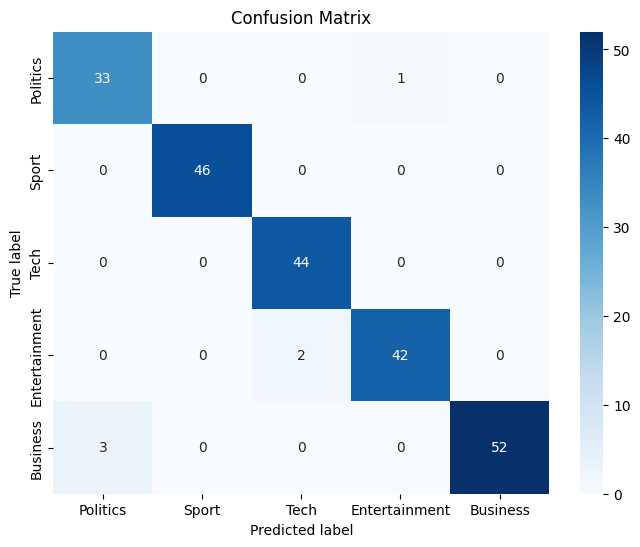

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppose you have predictions and true labels after evaluation or prediction:
# Example: after trainer.predict(test_dataset)

predictions_output = trainer.predict(tokenized_test)
logits = predictions_output.predictions
labels = predictions_output.label_ids

import numpy as np
preds = np.argmax(logits, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'],
            yticklabels=['Politics', 'Sport', 'Tech', 'Entertainment', 'Business'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score

# Run predictions on the test dataset
predictions_output = trainer.predict(tokenized_test)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted class indices
preds = np.argmax(logits, axis=-1)

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
target_names = ['Politics', 'Sport', 'Tech', 'Entertainment', 'Business']
report = classification_report(true_labels, preds, target_names=target_names)
print("Classification Report:\n", report)

Test Accuracy: 0.9731
Classification Report:
                precision    recall  f1-score   support

     Politics       0.92      0.97      0.94        34
        Sport       1.00      1.00      1.00        46
         Tech       0.96      1.00      0.98        44
Entertainment       0.98      0.95      0.97        44
     Business       1.00      0.95      0.97        55

     accuracy                           0.97       223
    macro avg       0.97      0.97      0.97       223
 weighted avg       0.97      0.97      0.97       223

